In [1]:
from cplex.callbacks import LazyConstraintCallback
from docplex.mp.callbacks.cb_mixin import *
from docplex.mp.model import Model
import numpy as np
import matplotlib.pyplot as plt
import requests

In [2]:
import requests
import numpy as np

def parse_vrp_instance(url, num_nodes):
    response = requests.get(url)

    if response.status_code == 200:
        content = response.text
        lines = content.split('\n')
        node_coord_index = lines.index('NODE_COORD_SECTION ')
        node_coord_lines = lines[node_coord_index + 1:]  # Start from NODE_COORD_SECTION

        # Parse the coordinates and reindex
        matrix_coord = []
        index = 0
        for line in node_coord_lines:
            values = line.split()
            if len(values) == 3:  # Ensure there are 3 values per line (index, x, y)
                x = int(values[1])
                y = int(values[2])
                matrix_coord.append([index, x, y])  # Append integer index
                index += 1
                if index == num_nodes:
                    break  # Stop parsing once desired number of nodes is reached

        return np.array(matrix_coord)
    else:
        print("Failed to retrieve VRP instance.")
        return None





In [10]:

url = 'http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n32-k5.vrp'
num_nodes = 8  # Decide the size of the matrix (number of nodes)
matrix_coord = parse_vrp_instance(url, num_nodes)


In [4]:
def instance_rsp(matrix_coord,alpha):
    size_matrix = len(matrix_coord)
    distance_matrix = np.zeros((size_matrix, size_matrix))

    for i in range(size_matrix):
        for j in range(i+1, size_matrix):
            # Extract coordinates for points i and j
            x1, y1 = matrix_coord[i, 1], matrix_coord[i, 2]
            x2, y2 = matrix_coord[j, 1], matrix_coord[j, 2]

            # Calculate Euclidean distance between points i and j
            distance_ij = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

            # Fill in the distance matrix
            distance_matrix[i, j] = np.round(distance_ij, 2)
            distance_matrix[j, i] = np.round(distance_ij, 2)

    c_matrix = alpha*distance_matrix
    d_matrix = (10-alpha)*distance_matrix

    return c_matrix, d_matrix


In [5]:
def solution_generate(size_problem):
    X = np.random.randint(2,size=(size_problem,size_problem))
    Y = np.random.randint(2,size=(size_problem,size_problem))
    return X,Y

In [6]:
def scatter_plot(X, Y, matrix_coords):
    # Get the size of the problem (size of the matrix)
    size_problem =len(matrix_coords)

    # Find the vertices in the cycle (where X[i, j] = 1)
    cycle_vertices = []
    for i in range(size_problem):
        for j in range(size_problem):
            if X[i, j] == 1:
                cycle_vertices.append(i)
                cycle_vertices.append(j)
    cycle_vertices = list(set(cycle_vertices))

    # Find the vertices outside the cycle
    outside_vertices = [i for i in range(size_problem) if i not in cycle_vertices]

    # Initialize outside_coords as an empty list
    outside_coords = []
    # Initialize outside_coords as an empty list
    outside_coords = []

    # Initialize cycle_coords as an empty list
    cycle_coords = []
    # Plot the vertices in the cycle
    if len(cycle_vertices)!=0:
        cycle_coords = [(i, matrix_coords[i][1], matrix_coords[i][2]) for i in cycle_vertices if i < len(matrix_coords)]
        cycle_x, cycle_y = zip(*[(x, y) for _, x, y in cycle_coords])
        plt.scatter(cycle_x, cycle_y, color='blue', label='Cycle Vertices')

    # Annotate each point with its index
    for idx, x, y in cycle_coords:
        plt.text(x+2, y+2, str(idx), color='black', fontsize=12, ha='center', va='center')

    # Plot the vertices outside the cycle
    if outside_vertices:  # Check if there are vertices outside the cycle
        outside_coords = [(i, matrix_coords[i][1], matrix_coords[i][2]) for i in outside_vertices if i < len(matrix_coords)]
        outside_x, outside_y = zip(*[(x, y) for _, x, y in outside_coords])
        plt.scatter(outside_x, outside_y, color='red', label='Outside Vertices')

        # Annotate each point with its index
        for idx, x, y in outside_coords:
            plt.text(x+2, y+2, str(idx), color='black', fontsize=12, ha='center', va='center')

    # Plot the arcs from the cycle to other points (where Y[i, j] = 1)
    if len(outside_vertices) != 0:
        for i in range(size_problem):
            for j in range(size_problem):
                if Y[i, j] == 1:
                    plt.plot([matrix_coords[i][1], matrix_coords[j][1]], [matrix_coords[i][2], matrix_coords[j][2]], color='green')

    # Plot the arcs within the cycle (where X[i, j] = 1)
    for i in range(size_problem):
        for j in range(size_problem):
            if X[i, j] == 1:
               
                plt.plot([matrix_coords[i][1], matrix_coords[j][1]], [matrix_coords[i][2], matrix_coords[j][2]], color='blue')

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Scatter Plot of Solution')
    plt.legend()
    plt.grid(True)
    plt.show()







In [7]:
import numpy as np

def check_solution(X, Y):
    n = X.shape[0]  # Number of vertices

    # Check if the depot constraint is satisfied
    if Y[0, 0] != 1:
        print("Depot constraint violated: Depot is not included in the cycle.")
        return False

    # Check if non-depot assignment constraints are satisfied
    if np.sum(Y[0,1:]) != 0:
        print("Non-depot assignment constraint violated: Depot is assigned to a vertex.")
        return False

    # Check connectivity constraints for each vertex (except the depot)
    for i in range(1, n):
        if np.sum(X[i, :]) != 2 * Y[i, i]:
            print(f"Connectivity constraint violated for vertex {i}: Degree is not 2.")
            return False

    # Check assignment constraints for each vertex (except the depot)
    for i in range(1, n):
        if np.sum(Y[i, :]) != 1:
            print(f"Assignment constraint violated for vertex {i}: Not assigned to exactly one vertex.")
            return False
    # Check if yij = 0 for all vi, vj in A (represented by X)
    if np.any(Y[X != 0] != 0):
        print("Violation of yij = 0 for all vi, vj in A constraint.")
    else:
        print("Constraint satisfied: yij = 0 for all vi, vj in A.")
    print("Solution is valid.")
    return True




In [8]:
import itertools
import numpy as np

import itertools
import numpy as np

def check_subtour_elimination(X, Y):
    n = X.shape[0]  # Size of the problem
    vertices = list(range(1, n ))  # List of vertices

    for k in range(2, n-1):
        subsets = itertools.combinations(vertices, k)
        for subset in subsets:
            left_sum = 0
                        
            for i in subset:
                for j in range(n):
                    if j not in subset:
                        left_sum += X[i][j] + X[j][i]
            for p in subset:
                right_sum = 0
                for q in subset:
                    right_sum +=Y[p][q]
                #print(subset,p,left_sum,right_sum)
                if left_sum < (2*right_sum):
                    print("Violating subset found:", subset)
                    return False  # Stop as soon as a violating subset is found

    return True  # All subtour elimination constraints satisfied






Constraint satisfied: yij = 0 for all vi, vj in A.
Solution is valid.
True


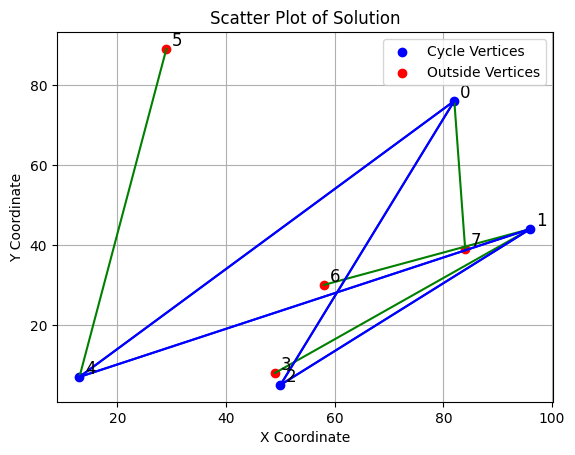

In [12]:

import numpy as np

Xtrue1 = np.array([
     [0, 0, 1, 0, 1, 0, 0, 0],
     [0, 0, 1, 0, 1, 0, 0, 0],
     [1, 1, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0],
     [1, 1, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0]
])

Ytrue1 = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0],
     [0, 1, 0, 0, 0, 0, 0, 0],
     [0, 0, 1, 0, 0, 0, 0, 0],
     [0, 1, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 1, 0, 0, 0],
     [0, 0, 0, 0, 1, 0, 0, 0],
     [0, 1, 0, 0, 0, 0, 0, 0],
     [1 ,0, 0, 0, 0, 0, 0, 0]
])

check_solution(Xtrue1,Ytrue1)
print(check_subtour_elimination(Xtrue1, Ytrue1))
scatter_plot(Xtrue1, Ytrue1, matrix_coord)

Constraint satisfied: yij = 0 for all vi, vj in A.
Solution is valid.
Violating subset found: (1, 2, 3)


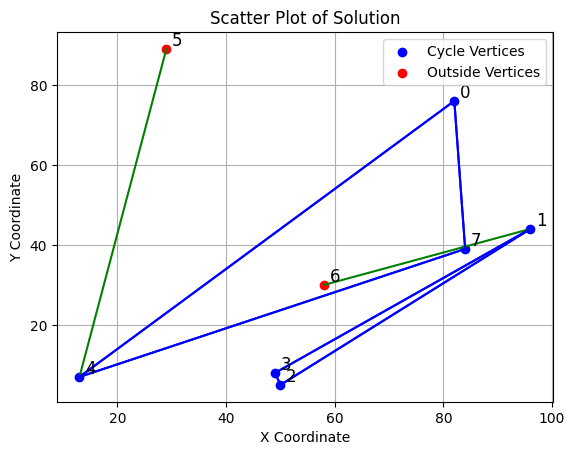

In [13]:
import numpy as np

Xtrue2 = np.array([
     [0, 0, 0, 0, 1, 0, 0, 1],
     [0, 0, 1, 1, 0, 0, 0, 0],
     [0, 1, 0, 1, 0, 0, 0, 0],
     [0, 1, 1, 0, 0, 0, 0, 0],
     [1, 0, 0, 0, 0, 0, 0, 1],
     [0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0],
     [1, 0, 0, 0, 1, 0, 0, 0]
])

Ytrue2 = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0],
     [0, 1, 0, 0, 0, 0, 0, 0],
     [0, 0, 1, 0, 0, 0, 0, 0],
     [0, 0, 0, 1, 0, 0, 0, 0],
     [0, 0, 0, 0, 1, 0, 0, 0],
     [0, 0, 0, 0, 1, 0, 0, 0],
     [0, 1, 0, 0, 0, 0, 0, 0],
     [0 ,0, 0, 0, 0, 0, 0, 1]
])
check_solution(Xtrue2,Ytrue2)
check_subtour_elimination(Xtrue2, Ytrue2)
scatter_plot(Xtrue2, Ytrue2, matrix_coord)

Assignment constraint violated for vertex 1: Not assigned to exactly one vertex.
Violating subset found: (1, 3)
False


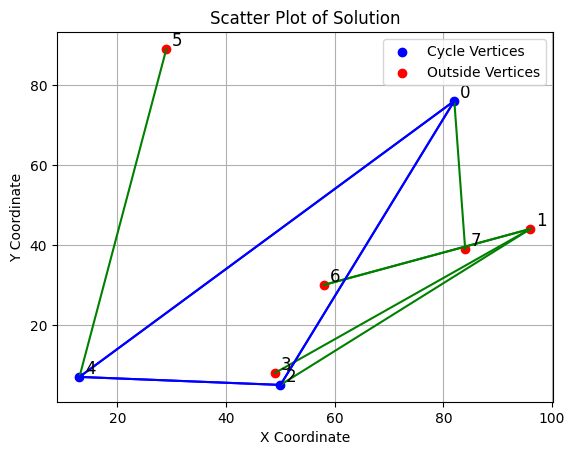

In [14]:

import numpy as np

Xtrue3 = np.array([
     [0, 0, 1, 0, 1, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0],
     [1, 0, 0, 0, 1, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0],
     [1, 0, 1, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0]
])

Ytrue3 = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 1, 0, 0, 0, 1, 0],
     [0, 0, 1, 0, 0, 0, 0, 0],
     [0, 1, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 1, 0, 0, 0],
     [0, 0, 0, 0, 1, 0, 0, 0],
     [0, 1, 0, 0, 0, 0, 0, 0],
     [1 ,0, 0, 0, 0, 0, 0, 0]
])

check_solution(Xtrue3,Ytrue3)
print(check_subtour_elimination(Xtrue3, Ytrue3))
scatter_plot(Xtrue3, Ytrue3, matrix_coord)

In [15]:

url = 'http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n32-k5.vrp'
num_nodes = 15  # Decide the size of the matrix (number of nodes)
matrix_coord = parse_vrp_instance(url, num_nodes)

Values of x:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Values of y:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0.

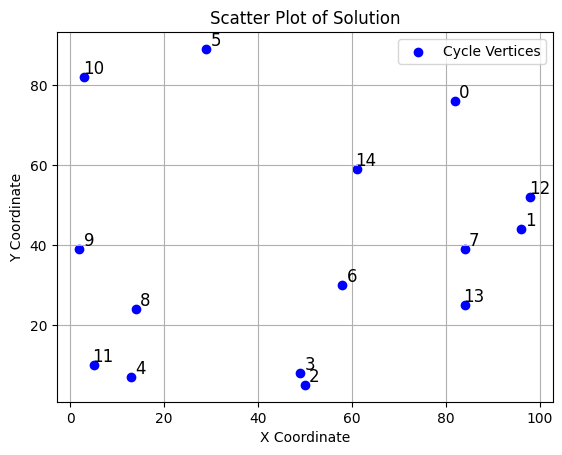

In [16]:
from docplex.mp.model import Model
import numpy as np

n = len(matrix_coord)
alpha = 7
C, D = instance_rsp(matrix_coord, alpha)



# Define your model
m = Model(name='Ring Star Problem')

x = {(i, j): m.binary_var(name=f'x[{i},{j}]') for i in range(n) for j in range(n) }
y = {(i, j): m.binary_var(name=f'y[{i},{j}]') for i in range(n) for j in range(n)}

# Add objective function
objective_expr = m.sum(x[(i, j)] * C[(i, j)] for i in range(n) for j in range(n))/2 + \
                 2*m.sum(y[(i, j)] * D[(i, j)] for i in range(n) for j in range(n))

# Change the objective function
m.minimize(objective_expr)
# Add constraints
for i in range(n):
    m.add_constraint(m.sum((x[(i, j)] + x[(j, i)]) for j in range(n)) == 2 * y[(i, i)])

for i in range(1, n):
    m.add_constraint(m.sum(y[(i, j)] for j in range(n)) == 1)

m.add_constraint(y[(0, 0)] == 1)

m.add_constraint(m.sum(y[(0, j)] for j in range(1, n)) == 0)


# Solve the model
sol = m.solve()
#print(sol)



# Get the values of x and y variables from the solution
X_values = np.zeros((n, n))
Y_values = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        X_values[i, j] = sol.get_var_value(x[(i, j)])
        Y_values[i, j] = sol.get_var_value(y[(i, j)])

# Print the values of x and y
print("Values of x:")
print(X_values)
print("Values of y:")
print(Y_values)
scatter_plot(X_values, Y_values, matrix_coord)

In [17]:



url = 'http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n32-k5.vrp'
num_nodes = 15  # Decide the size of the matrix (number of nodes)
matrix_coord = parse_vrp_instance(url, num_nodes)




from docplex.mp.model import Model
import numpy as np
import itertools
n = len(matrix_coord)
alpha = 8.7
C, D = instance_rsp(matrix_coord, alpha)



# Define your model
m = Model(name='Ring Star Problem')

x = {(i, j): m.binary_var(name=f'x[{i},{j}]') for i in range(n) for j in range(n) }
y = {(i, j): m.binary_var(name=f'y[{i},{j}]') for i in range(n) for j in range(n)}

# Add objective function
objective_expr = m.sum(x[(i, j)] * C[(i, j)] for i in range(n) for j in range(n)) + \
                 2*m.sum(y[(i, j)] * D[(i, j)] for i in range(n) for j in range(n))

# Change the objective function
m.minimize(objective_expr)
# Add constraints
for i in range(n):
    m.add_constraint(m.sum((x[(i, j)] + x[(j, i)]) for j in range(n)) == 2 * y[(i, i)])

for i in range(1, n):
    m.add_constraint(m.sum(y[(i, j)] for j in range(n)) == 1)

m.add_constraint(y[(0, 0)] == 1)

m.add_constraint(m.sum(y[(0, j)] for j in range(1, n)) == 0)
vertices = list(range(1, n ))
for k in range(1, n-1):
        subsets = itertools.combinations(vertices, k)
        for subset in subsets:
            left_sum = 0
                        
            for i in subset:
                for j in range(n):
                    if j not in subset:
                        left_sum += x[(i, j)] + x[(j, i)]
            for p in subset:
                right_sum = 0
                for q in subset:
                    right_sum +=y[(p,q)]
                #print(subset,p,left_sum,right_sum)
                m.add_constraint(left_sum >= 2 * right_sum)

# Solve the model
sol = m.solve()
objective_value = sol.get_objective_value()

# Print the objective value
print("Objective value:", objective_value)



# Get the values of x and y variables from the solution
X_values = np.zeros((n, n))
Y_values = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        X_values[i, j] = sol.get_var_value(x[(i, j)])
        Y_values[i, j] = sol.get_var_value(y[(i, j)])

# Print the values of x and y
print("Values of x:")
print(X_values)
print("Values of y:")
print(Y_values)

    

Objective value: 2118.1450000000004
Values of x:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Values of y:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.

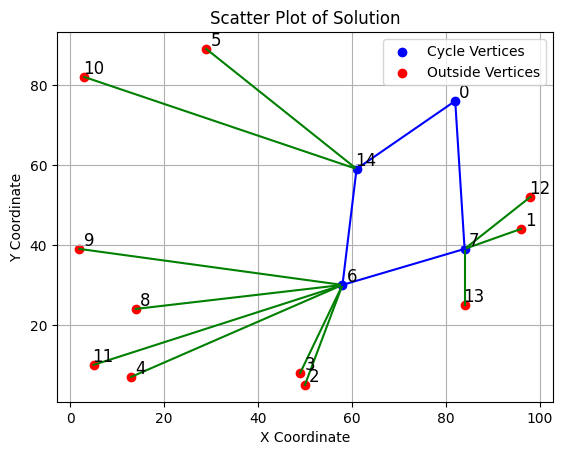

In [18]:
 scatter_plot(X_values, Y_values, matrix_coord)

In [20]:
from docplex.mp.model import Model
import numpy as np
import itertools
import time


url = 'http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n32-k5.vrp'
num_nodes = 15  # Decide the size of the matrix (number of nodes)
matrix_coord = parse_vrp_instance(url, num_nodes)

def solve_and_plot(matrix_coord, alpha):
    start_time = time.time()  # Record the start time
    n = len(matrix_coord)
    C, D = instance_rsp(matrix_coord, alpha)

    # Define your model
    m = Model(name='Ring Star Problem')

    x = {(i, j): m.binary_var(name=f'x[{i},{j}]') for i in range(n) for j in range(n) }
    y = {(i, j): m.binary_var(name=f'y[{i},{j}]') for i in range(n) for j in range(n)}

    # Add objective function
    objective_expr = m.sum(x[(i, j)] * C[(i, j)] for i in range(n) for j in range(n)) + \
                     2*m.sum(y[(i, j)] * D[(i, j)] for i in range(n) for j in range(n))

    # Change the objective function
    m.minimize(objective_expr)
    # Add constraints
    for i in range(n):
        m.add_constraint(m.sum((x[(i, j)] + x[(j, i)]) for j in range(n)) == 2 * y[(i, i)])

    for i in range(1, n):
        m.add_constraint(m.sum(y[(i, j)] for j in range(n)) == 1)

    m.add_constraint(y[(0, 0)] == 1)

    m.add_constraint(m.sum(y[(0, j)] for j in range(1, n)) == 0)
    vertices = list(range(1, n ))
    for k in range(1, n-1):
            subsets = itertools.combinations(vertices, k)
            for subset in subsets:
                left_sum = 0

                for i in subset:
                    for j in range(n):
                        if j not in subset:
                            left_sum += x[(i, j)] + x[(j, i)]
                for p in subset:
                    right_sum = 0
                    for q in subset:
                        right_sum +=y[(p,q)]
                    #print(subset,p,left_sum,right_sum)
                    m.add_constraint(left_sum >= 2 * right_sum)

    # Solve the model
    sol = m.solve()
    objective_value = sol.get_objective_value()
    solve_time = time.time() - start_time
    print("Solve time:", solve_time, "seconds")
    # Print the objective value
    print("Objective value:", objective_value)

    # Get the values of x and y variables from the solution
    X_values = np.zeros((n, n))
    Y_values = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            X_values[i, j] = sol.get_var_value(x[(i, j)])
            Y_values[i, j] = sol.get_var_value(y[(i, j)])

    # Print the values of x and y
    print("Values of x:")
    print(X_values)
    print("Values of y:")
    print(Y_values)

    # Plot the solution
    scatter_plot(X_values, Y_values, matrix_coord)
    return X_values, Y_values, objective_value, solve_time


Solve time: 21.590993404388428 seconds
Objective value: 2143.2480000000005
Values of x:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Values of y:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

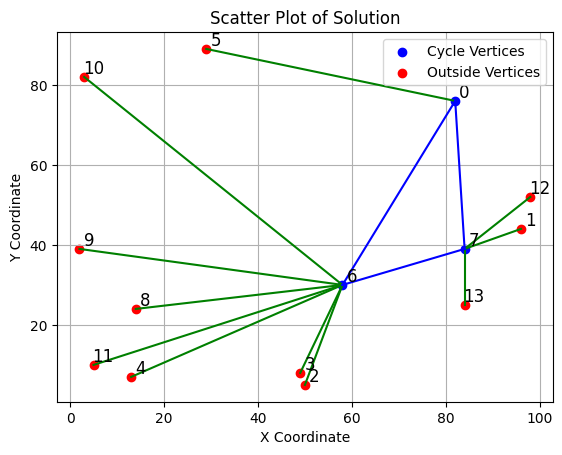

In [21]:
url = 'http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n32-k5.vrp'
num_nodes = 14  # Decide the size of the matrix (number of nodes)
matrix_coord = parse_vrp_instance(url, num_nodes)
A = solve_and_plot(matrix_coord,8.7 )

Solve time: 0.07495331764221191 seconds
Objective value: 1020.2920000000006
Values of x:
[[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
Values of y:
[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


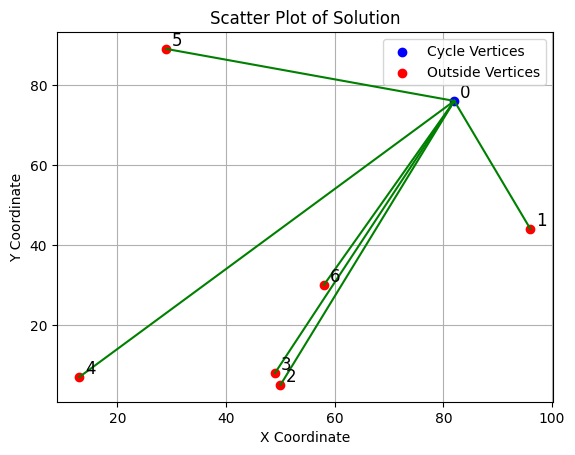

Solve time: 0.1839897632598877 seconds
Objective value: 1116.6220000000008
Values of x:
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Values of y:
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


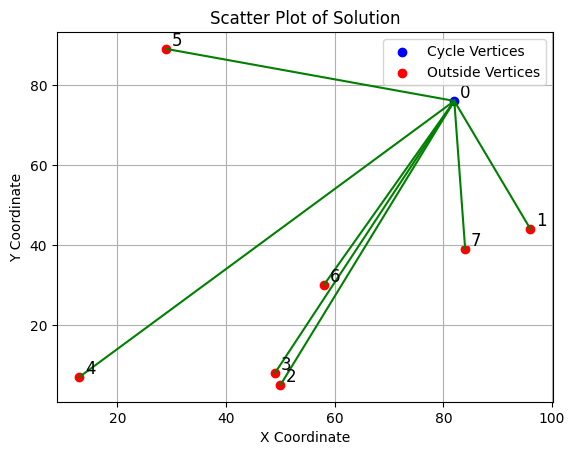

Solve time: 0.2779405117034912 seconds
Objective value: 1339.1820000000007
Values of x:
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Values of y:
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]]


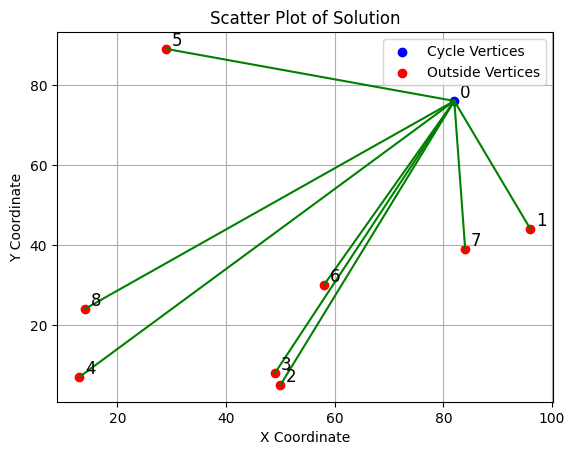

Solve time: 0.6019811630249023 seconds
Objective value: 1568.346000000001
Values of x:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Values of y:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


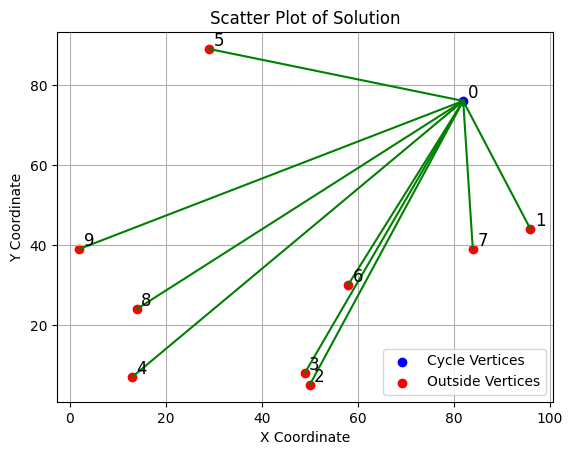

Solve time: 1.53299880027771 seconds
Objective value: 1774.344000000001
Values of x:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Values of y:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


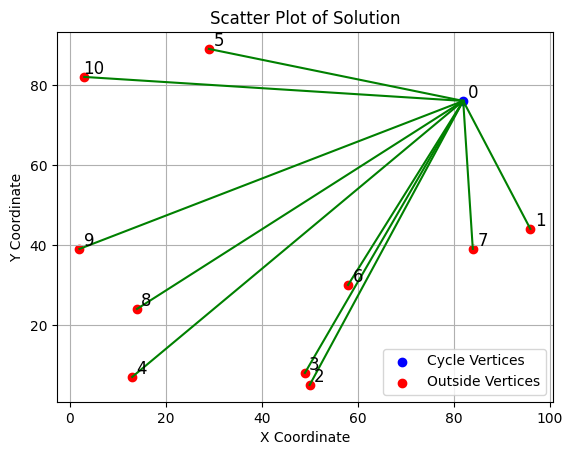

Solve time: 4.16186261177063 seconds
Objective value: 2038.0100000000011
Values of x:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Values of y:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1

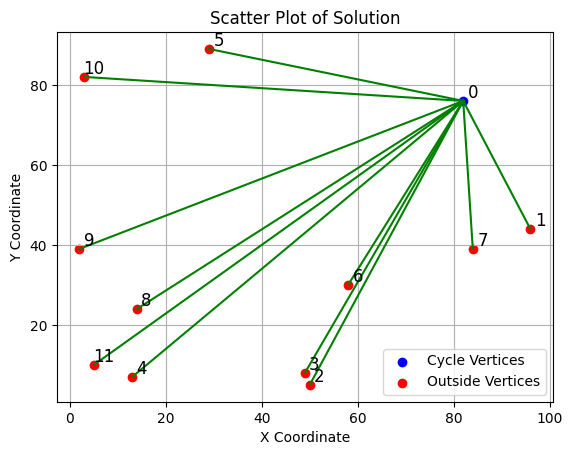

Solve time: 9.087953090667725 seconds
Objective value: 2106.848
Values of x:
[[-1.11022302e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00

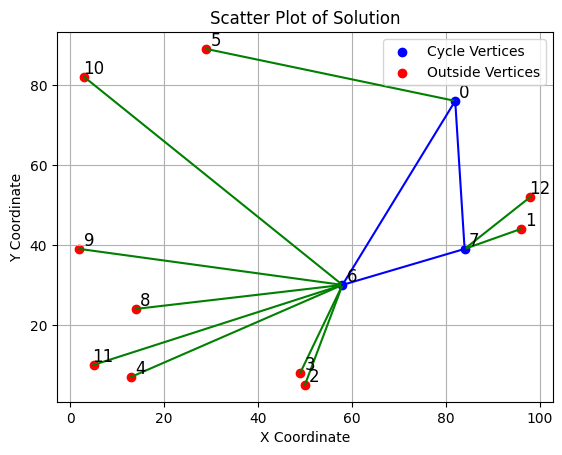

Solve time: 22.00799036026001 seconds
Objective value: 2143.2480000000005
Values of x:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Values of y:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

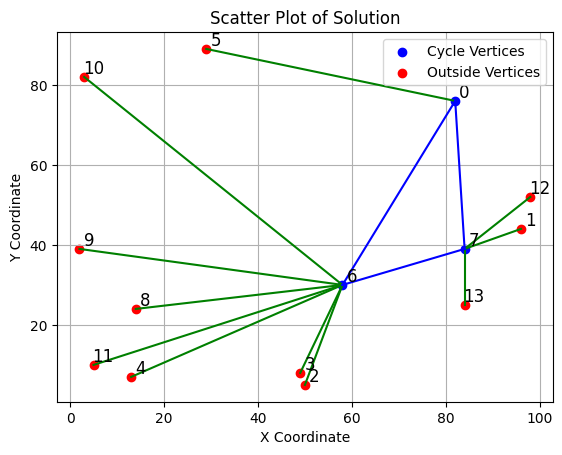

Solve time: 63.99030303955078 seconds
Objective value: 2118.1450000000004
Values of x:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Values of y:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 

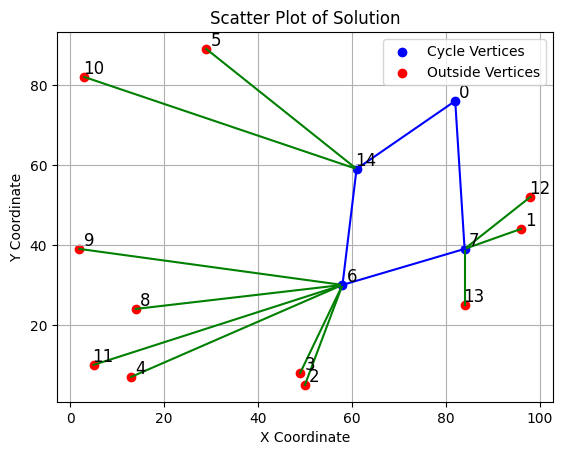

Solve time: 143.36041140556335 seconds
Objective value: 2274.925
Values of x:
[[1.11022302e-16 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00

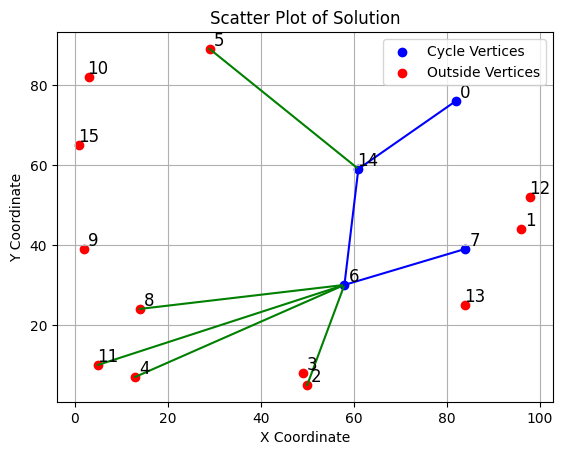

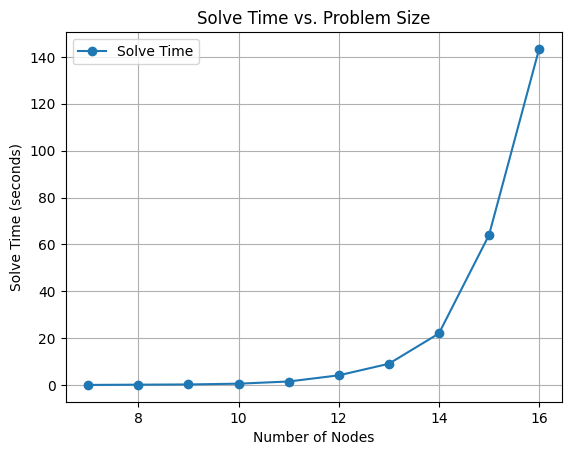

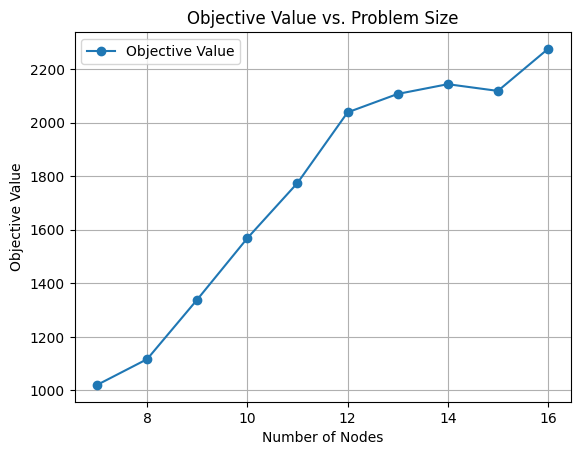

In [22]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import time

problem_sizes = range(7, 17)  # Change the range according to your requirement
solve_times = []
objective_values = []

for num_nodes in problem_sizes:
    url = 'http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n32-k5.vrp'
    matrix_coord = parse_vrp_instance(url, num_nodes)
    
    X_values, Y_values, objective_value, solve_time = solve_and_plot(matrix_coord, 8.7)
    
    solve_times.append(solve_time)
    objective_values.append(objective_value)

# Plot the solve time against the size of the problem
plt.plot(problem_sizes, solve_times, marker='o', label='Solve Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Solve Time (seconds)')
plt.title('Solve Time vs. Problem Size')
plt.grid(True)
plt.legend()
plt.show()

# Plot the objective value against the size of the problem
plt.plot(problem_sizes, objective_values, marker='o', label='Objective Value')
plt.xlabel('Number of Nodes')
plt.ylabel('Objective Value')
plt.title('Objective Value vs. Problem Size')
plt.grid(True)
plt.legend()
plt.show()
